In [2]:
import torch
from torch import nn, einsum, Tensor
from einops import rearrange, repeat
import torch.nn.functional as F

In [3]:
def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def exists(val):
    return val is not None


In [4]:
class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.register_buffer("beta", torch.zeros(dim))

    def forward(self, x):
        return F.layer_norm(x, x.shape[-1:], self.gamma, self.beta)


tensor([0., 0., 1., 1., 2., 2., 3., 3., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5.])


/tmp/ipykernel_260617/3004785463.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return_token_types_tensor = torch.tensor(return_token_types)


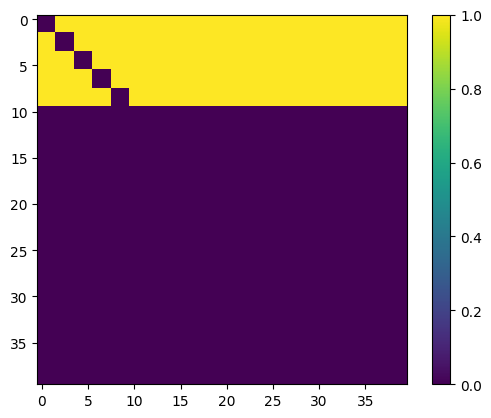

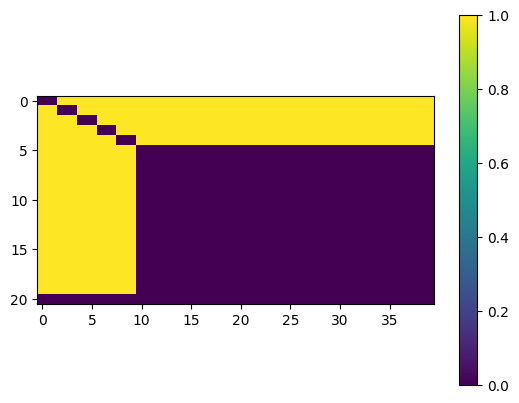

In [87]:
import matplotlib.pyplot as plt
from einops import rearrange

def create_zorro_mask(token_types, fusion_token):
    token_types_attend_from = rearrange(token_types, 'i -> i 1')
    token_types_attend_to = rearrange(token_types, 'j -> 1 j')
    zorro_mask = token_types_attend_from == token_types_attend_to
    zorro_mask = zorro_mask | (token_types_attend_from == fusion_token)
    zorro_mask = zorro_mask #| torch.eye(token_types.shape[0],token_types.shape[0]).to(torch.bool)
    #zorro_mask = repeat(zorro_mask, 'j i -> i j')
    return ~zorro_mask #.to(torch.long)
def create_zorro_pooling_mask(token_types, return_token_types_tensor, global_token):
    token_types_attend_to = rearrange(token_types, 'j -> 1 j')
    pool_mask = rearrange(return_token_types_tensor, 'i -> i 1') == token_types_attend_to
    # global queries can attend to all tokens
    pool_mask = pool_mask | (rearrange(return_token_types_tensor, 'i -> i 1') == torch.ones_like(
        token_types_attend_to, dtype=torch.long) * global_token)
    return ~pool_mask

#plt.imshow(create_zorro_mask(token_types, 3))
num_token_types = 5 #Nonfusion types here
num_fusion_tokens = 30
fusion_tokens_per = 2
fusion_token = num_token_types
global_token = fusion_token+1
token_types = torch.cat([torch.ones(2)*i for i in range(num_token_types)]+[torch.ones(num_fusion_tokens)*num_token_types])
print(token_types)
zorro_mask = create_zorro_mask(token_types, fusion_token)
#zorro_mask=zorro_mask & ~torch.eye(token_types.shape[0],token_types.shape[0]).to(torch.bool)
plt.imshow(zorro_mask)
plt.colorbar()
return_token_types = torch.cat([torch.ones(1)*i for i in range(num_token_types)]+[torch.ones(int(num_fusion_tokens/fusion_tokens_per))*num_token_types]+[torch.ones(1)*global_token])
return_token_types_tensor = torch.tensor(return_token_types)
pool_mask=create_zorro_pooling_mask(token_types, return_token_types, global_token)
plt.figure()
plt.imshow(pool_mask)
plt.colorbar()

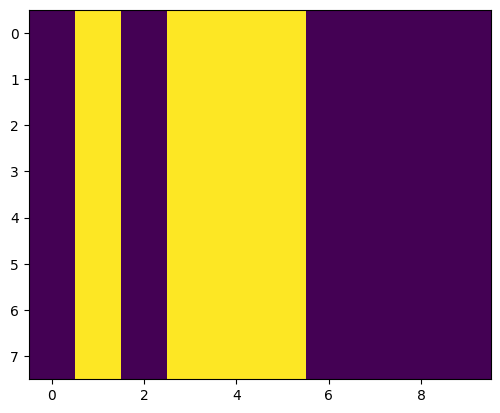

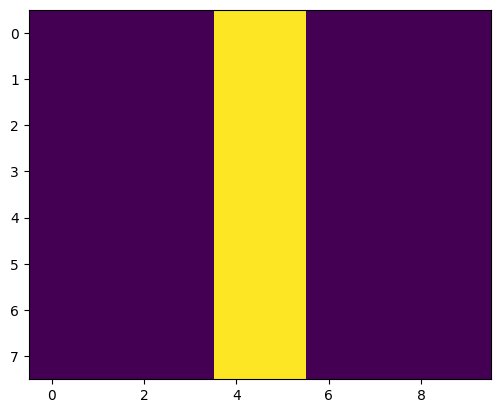

In [77]:
padding_mask = torch.cat([torch.zeros(1),
                          torch.ones(1),
                          torch.zeros(1), 
                          torch.ones(1),
                          torch.ones(2), 
                          torch.zeros(4)]).to(torch.bool)#.unsqueeze(0)
padding_mask2 = torch.cat([torch.zeros(4), 
                          torch.ones(2), 
                          torch.zeros(4)]).to(torch.bool)#.unsqueeze(0)
padding_mask = torch.stack([padding_mask, padding_mask2])
p=padding_mask.unsqueeze(1).repeat(1,8,1)
plt.imshow(p[0])
plt.figure()
plt.imshow(p[1])

In [78]:
from itertools import chain, combinations
def adjusted_powerset(it, powers = [2,3]):
    yield from chain.from_iterable(combinations(it, r) for r in powers)

def create_mfdoom_mask(zorro_mask, 
                       fusion_token, 
                       #num_fusion_tokens, 
                       #powers=[1,3], 
                       token_combos,
                       isolated_fusion=True):
    """
    Create the MFDoom mask. Must have num_fusion_tokens//num_modalities == 0
    """
    print(token_combos)
    num_fusion_tokens = (token_types == fusion_token).sum()
    assert num_fusion_tokens % len(token_combos) == 0, f"Number of fusion tokens {num_fusion_tokens} must be divisible by the number of combinations {len(token_combos)}"
    nsubtok = int(num_fusion_tokens / len(token_combos))
    
    mfdoom_mask = [~torch.isin(token_types,torch.Tensor(i)) for i in token_combos]
    
    fusion_tokens = token_types == fusion_token
    subfusion_tokens = torch.split(fusion_tokens.nonzero(), nsubtok)
    for idx, mfdoom in enumerate(mfdoom_mask):
        mfdoom[fusion_tokens] = True
        mfdoom[subfusion_tokens[idx]] = False
        mfdoom_mask[idx] = mfdoom
    mfdoom_mask = repeat(mfdoom_mask, 'i j -> (i i2) j', i2=nsubtok)
    zorro_mask[token_types == fusion_token] = mfdoom_mask
    return zorro_mask

In [88]:
def create_mfdoom_pooling_mask( token_combos,
                                return_token_types_tensor,
                               pool_mask,
                                num_fusion_tokens,
                                fusion_token):
    assert num_fusion_tokens % len(token_combos) == 0, f"Number of fusion tokens {num_fusion_tokens} must be divisible by the number of combinations {len(token_combos)}"
    nsubtok = int(num_fusion_tokens / len(token_combos))
    print(nsubtok)
    fusion_blocks = [torch.ones((1, nsubtok))
                     for _ in range(len(token_combos))]
    mfdoom_pool_mask = torch.block_diag(*fusion_blocks)
    select_mask = (return_token_types_tensor == fusion_token).unsqueeze(1) * \
                  (token_types == fusion_token).unsqueeze(0)
    pool_mask[select_mask] = ~mfdoom_pool_mask.to(torch.bool).flatten()
    return pool_mask

In [100]:
u=frozenset(['z','x','y'])
z=sorted(list(u))
print(z)

['x', 'y', 'z']


15
[(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 3), (0, 2, 4), (0, 3, 4), (1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4), (0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 3, 4), (0, 2, 3, 4), (1, 2, 3, 4)]


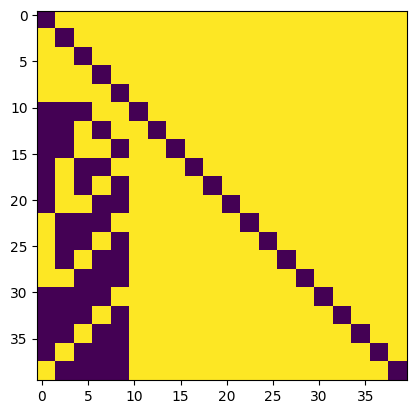

In [90]:
token_combos = list(adjusted_powerset([0,1,2,3,4], [3,4]))
print(len(token_combos))
plt.imshow(create_mfdoom_mask(zorro_mask,5,token_combos))

2


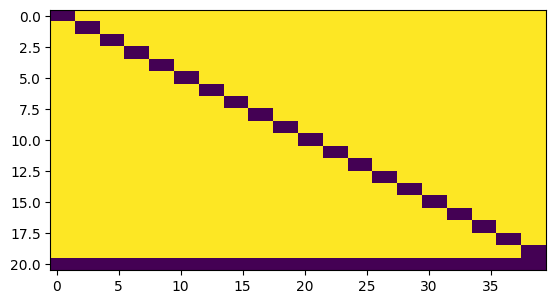

In [91]:
mfdpm=create_mfdoom_pooling_mask(token_combos,
                                 return_token_types_tensor,
                               pool_mask,
                               num_fusion_tokens,
                               fusion_token)
plt.imshow(mfdpm)

In [72]:
class Attention(nn.Module):
    def __init__(
            self,
            dim,
            dim_head=64,
            heads=8
    ):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm = LayerNorm(dim)

        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(
            self,
            x,
            context=None,
            attn_mask=None,
            key_padding_mask=None,
            return_attn=False
    ):
        x = self.norm(x)
        kv_x = default(context, x)

        q, k, v = (self.to_q(x), *self.to_kv(kv_x).chunk(2, dim=-1))

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), (q, k, v))

        q = q * self.scale
        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        if exists(attn_mask):
            sim = sim.masked_fill(attn_mask, -torch.finfo(sim.dtype).max)
        if exists(key_padding_mask):
            key_padding_mask = repeat(key_padding_mask, "b i -> b h j i", h=self.heads, j=sim.shape[-2])
            sim = sim.masked_fill(key_padding_mask, -torch.finfo(sim.dtype).max)
        
        attn = sim.softmax(dim=-1)
        out = einsum('b h i j, b h j d -> b h i d', attn, v) #j is number of toks
        out = rearrange(out, 'b h n d -> b n (h d)')
        if return_attn:
            return self.to_out(out), attn, v
            #return self.to_out(out), attn
        else:
            return self.to_out(out)

In [681]:
# geglu feedforward
class GEGLU(nn.Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim=-1)
        return F.gelu(gate) * x


class FeedForward(nn.Module):
    def __init__(self,
                dim,
                mult=4):
        super().__init__()
        inner_dim = int(dim * mult * 2 / 3)

        self.feedforward = nn.Sequential(
            nn.Linear(dim, inner_dim * 2, bias=False),
            GEGLU(),
            nn.Linear(inner_dim, dim, bias=False)
            )
    def forward(self, batch):
        return self.feedforward(batch)


In [682]:
ff = FeedForward(3)

In [660]:
attn=Attention(3,2,1)
print(padding_mask.shape)

torch.Size([2, 10])


In [667]:
#batch=torch.ones(1,8,3)#torch.randn(1,8,3)
batch = torch.randn(1,10,3)
batch = torch.cat([batch,batch])
crossbatch = torch.randn(2,5,3)

In [668]:
mask = mfdm
print(mask.shape)

torch.Size([10, 10])


In [669]:
#res1,a1, v1=attn(crossbatch, batch, attn_mask=pool_mask,key_padding_mask=padding_mask,return_attn=True)

In [688]:
res1,a1,v1=attn(batch, batch, attn_mask=mask,key_padding_mask=padding_mask, return_attn=True)

In [689]:
res1,a1,v1=res1.detach(),a1.detach(),v1.detach()

In [690]:
res1=ff(res1).detach()
print(res1.shape)

torch.Size([2, 10, 3])


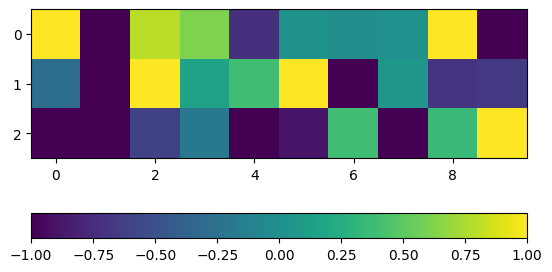

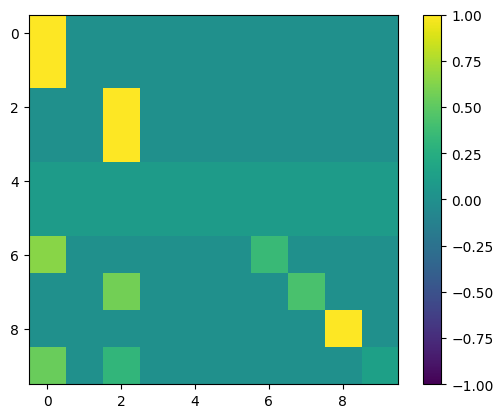

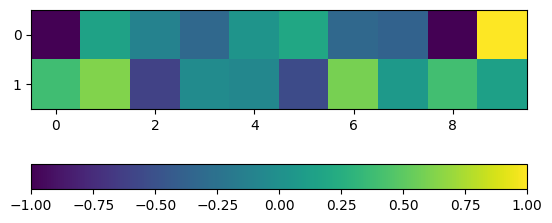

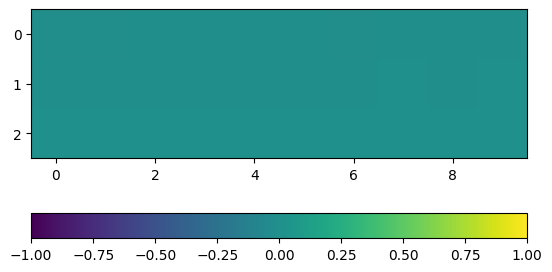

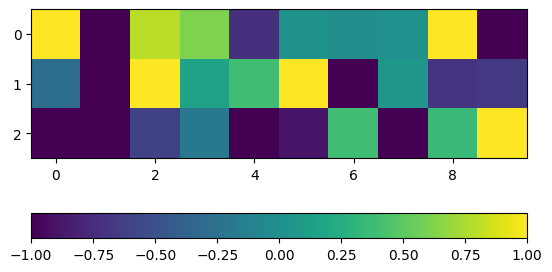

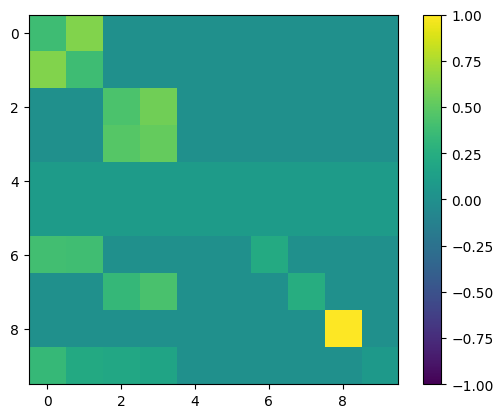

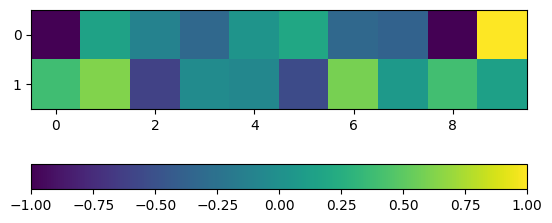

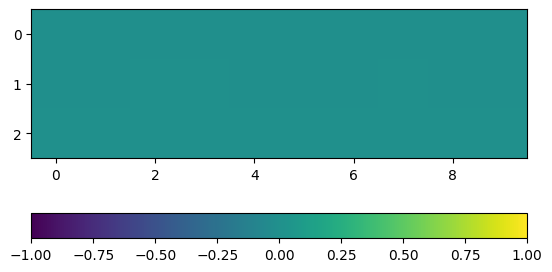

In [691]:
lim={'vmin':-1,'vmax':1}
plt.imshow(batch[0,:,:].T,**lim)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(a1[0,0,:,:],**lim)
plt.colorbar()
plt.figure()
plt.imshow(v1[0,0,:,:].T,**lim)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(res1[0,:,:].T,**lim)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(batch[1,:,:].T,**lim)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(a1[1,0,:,:],**lim)
plt.colorbar()
plt.figure()
plt.imshow(v1[1,0,:,:].T,**lim)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(res1[1,:,:].T,**lim)
plt.colorbar(orientation='horizontal')

In [692]:
import copy
batch2 = copy.deepcopy(batch)
batch2[:,1,:] = 999

In [693]:
batch==batch2

tensor([[[ True,  True,  True],
         [False, False, False],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [False, False, False],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]])

In [694]:
res2,a2,v2 = attn(batch2, batch2, attn_mask=mask,key_padding_mask=padding_mask, return_attn=True)
#res2,a2,v2 = attn(crossbatch, batch2, attn_mask=pool_mask,key_padding_mask=padding_mask, return_attn=True)
res2,a2,v2 = res2.detach(), a2.detach(), v2.detach()
res2=ff(res2).detach()
print(res1.shape)

torch.Size([2, 10, 3])


<Figure size 640x480 with 0 Axes>

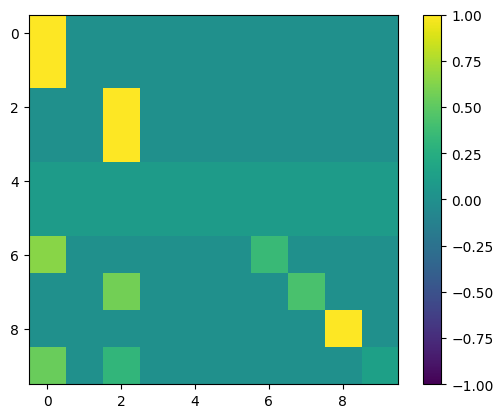

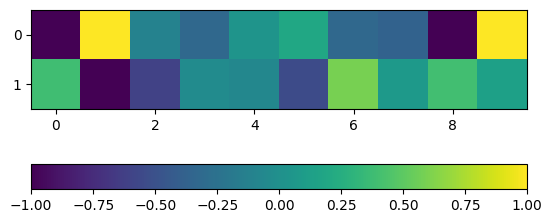

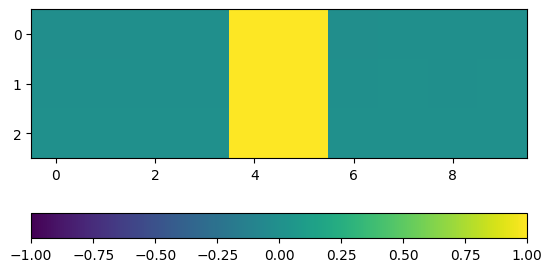

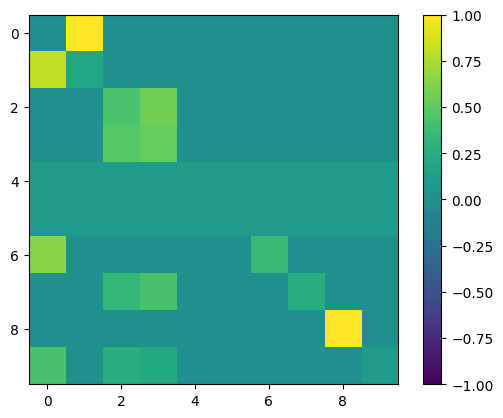

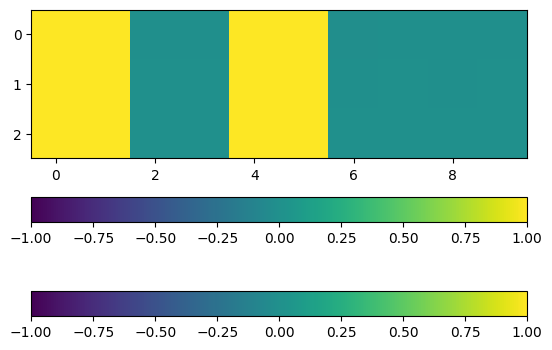

<Figure size 640x480 with 0 Axes>

In [695]:
plt.imshow(a2[0,0,:,:],**lim)
plt.colorbar()
plt.figure()
plt.imshow(v2[0,0,:,:].T,**lim)
plt.colorbar(orientation="horizontal")
plt.figure()
plt.imshow(res2[0,:,:].T,**lim)
plt.colorbar(orientation="horizontal")
plt.figure()
plt.imshow(a2[1,0,:,:],**lim)
plt.colorbar()
plt.figure()
plt.imshow(v2[1,0,:,:].T,**lim)
plt.colorbar(orientation="horizontal")
plt.imshow(res2[1,:,:].T,**lim)
plt.colorbar(orientation="horizontal")
plt.figure()

In [696]:
res12=res1==res2
a12 = a1 == a2

In [697]:
res12.shape

torch.Size([2, 10, 3])

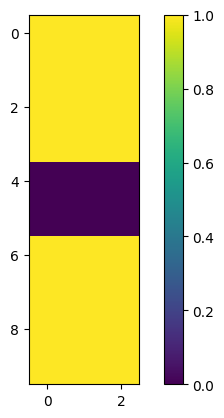

In [698]:
plt.imshow(res12[0,:,:])
plt.colorbar()

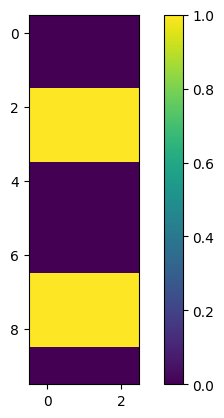

In [699]:
plt.imshow(res12[1,:,:])
plt.colorbar()

In [109]:
t=[torch.tensor([1,0,1,1,1]), torch.tensor([0,1,1,1,1]), torch.tensor([0,0,1,1,0])]

In [111]:
torch.stack(t).prod(dim=0)

tensor([0, 0, 1, 1, 0])

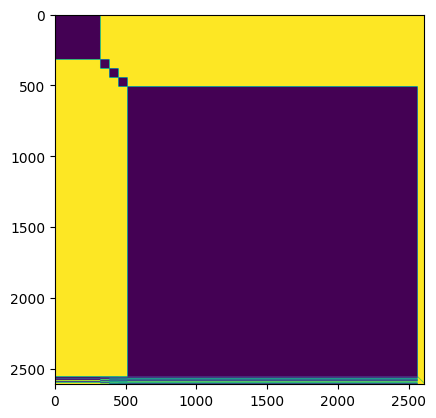

In [123]:
x=torch.load('../attn_mask.pt')
plt.imshow(x)#, aspect=100)


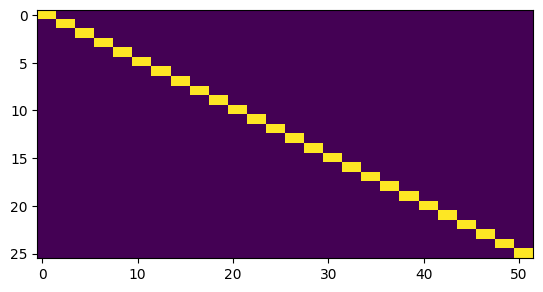

In [118]:
y=torch.load('../pool_mask.pt')
plt.imshow(y)


In [125]:
1612/52

31.0

In [120]:
y.shape

torch.Size([26, 52])

In [121]:
26*52

1352

In [126]:
False * False

0